In [2]:
suppressMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(tidyverse)
    library(harmony)
    library(ggrepel)
    library(ggrastr)
    library(magrittr)
    # GO enrich use packages
    library(DOSE)
    library(clusterProfiler)
    library(org.Hs.eg.db)
    library(ggplot2)
    library(dplyr)
    library(topGO)
    library(GSEABase)
    library(stringr)
    library(RColorBrewer)
    ## RNA velocity
    library(velocyto.R)
})

# define some functions

In [ ]:
celltype.genes.exp <- function(seuObj, select.genes){
    select.exp <- seuObj@assays$RNA@data[select.genes, ] %>% as.matrix() %>% as.data.frame()
    select.exp <- t(select.exp) %>% as.data.frame()
    select.exp$celltype <- Idents(seuObj)[rownames(select.exp)]
    df <- reshape2::melt(select.exp, id=c("celltype"))
    colnames(df)[2:3] <- c("gene", "exp")
    return(df)
}

getGSEA.GO <- function(marker.df){
    keep.entrezID <- bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")
    marker.df <- marker.df[keep.entrezID$SYMBOL,]
    use.genes <- structure(unlist(marker.df$avg_log2FC), names=rownames(marker.df))
    use.genes <- use.genes[order(use.genes, decreasing = T)]
    names(use.genes) <- keep.entrezID$ENTREZID[match(names(use.genes), keep.entrezID$SYMBOL)]
    em <- gseGO(geneList=use.genes, 
                 ont ="BP", 
                 keyType = "ENTREZID", 
                 nPerm = 10000, 
                 minGSSize = 3, 
                 maxGSSize = 800, 
                 pvalueCutoff = 0.05, 
                 verbose = TRUE, 
                 OrgDb = org.Hs.eg.db, 
                 pAdjustMethod = "BH")
    return(em)
}
getGSEA <- function(marker.df, term2gene = H_t2g){
    keep.entrezID <- bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")
    marker.df <- marker.df[keep.entrezID$SYMBOL,]
    use.genes <- structure(unlist(marker.df$avg_log2FC), names=rownames(marker.df))
    use.genes <- use.genes[order(use.genes, decreasing = T)]
    names(use.genes) <- keep.entrezID$ENTREZID[match(names(use.genes), keep.entrezID$SYMBOL)]
    em <- GSEA(use.genes, TERM2GENE = term2gene, pvalueCutoff = 0.05)
    return(em)
}

In [3]:
suppressMessages(
    source("~/project/2020-6-18-IVDD_scRNA/scripts/R_scripts/preferable_scripts/common_use_functions.R")
)  

# load and save vars

In [61]:
save.image("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_np_penc_seu_plots.RData")

In [4]:
load("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_np_penc_seu_plots.RData")

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [5]:
penc.seu <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_np_penc_seu.Rds")

In [31]:
sample.info <- penc.seu@meta.data %>% dplyr::select(orig.ident, sample_name)

In [32]:
write.table(sample.info,
            file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_penc_celltype_infos.txt",
            sep = '\t', quote=F)

In [9]:
saveRDS(penc.seu, 
       file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_np_penc_seu.Rds")

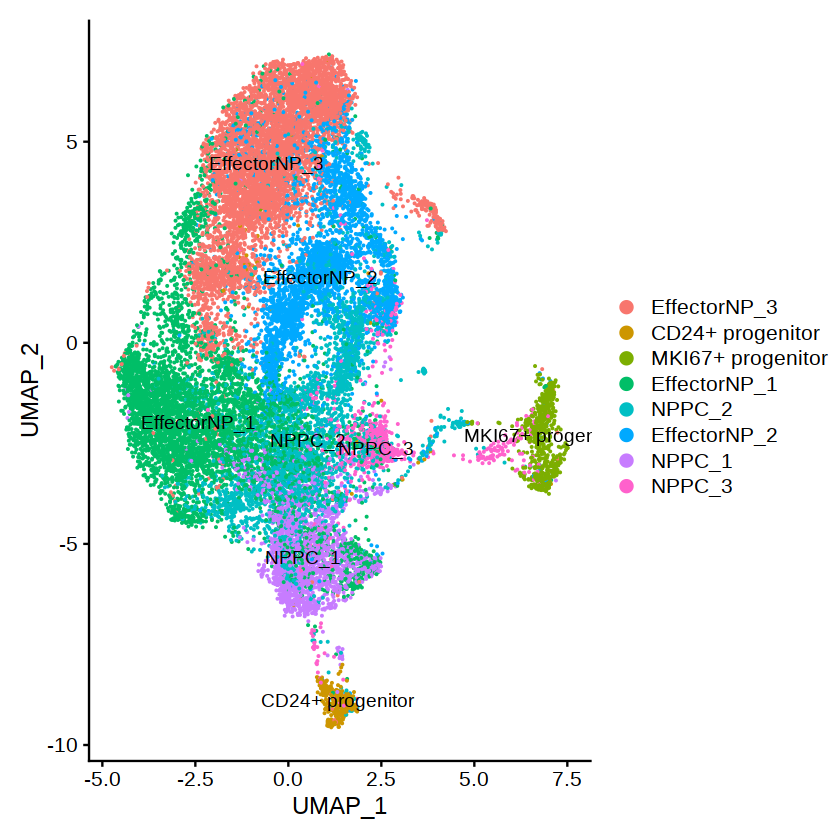

In [8]:
DimPlot(penc.seu, label = T)

In [166]:
saveRDS(penc.seu@meta.data, file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/test_check_diff_seu_meta_df.Rds")

In [34]:
penc.seu@meta.data$ct.np.detail.refine %>% unique()

[1] "ossification_effector_NP"     "CD24+ progenitor"            
 [3] "MKI67+ progenitor"            "pre-ossification_effector_NP"
 [5] "cartilage_dev_effector_NP"    "NPPC_2"                      
 [7] "CYTL1+ NP"                    "NPPC_1"                      
 [9] "NPPC_3"                       "HomNP"

# re-fine

In [ ]:
penc.seu <- Seurat.wf(penc.seu)

In [ ]:
set.seed(21)
penc.seu <-
  RunHarmony(
    penc.seu,
    group.by.vars = "sample_name"
  )


In [ ]:
penc.seu <- penc.seu %>% 
  RunUMAP(reduction = "harmony", dims = 1:70) %>% 
  FindNeighbors(reduction = "harmony", dims = 1:70) %>% 
  FindClusters(resolution = 1.5) %>% 
  identity()


In [76]:
options(repr.plot.width=14, repr.plot.height=10)

# re-sign celltype

In [140]:
Idents(penc.seu) <- penc.seu@meta.data$ct.np.detail.refine2

In [ ]:
test.penc.markers <- 
    FindAllMarkers(penc.seu, min.pct = 0.2, only.pos = TRUE, test.use="MAST")

In [169]:
write.table(test.penc.markers, 
        file = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/PENC_new_refine_markers2.txt",
        sep='\t', row.names=F, quote=F)

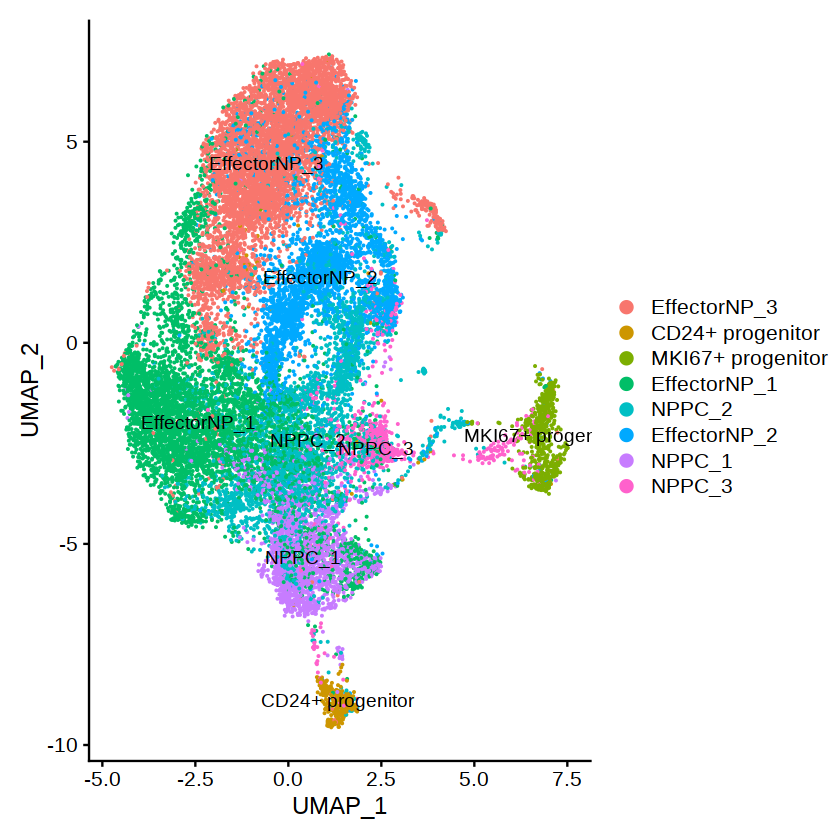

In [56]:
DimPlot(penc.seu, label = T)

In [145]:
embed.mx <- Embeddings(penc.seu, "umap")
cluster.labels <- penc.seu$ct.np.detail.refine2
slinshot.mats <- list(embed.mx, cluster.labels)
saveRDS(slinshot.mats,
        file="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/penc_slingshot_mats_renew.Rds")

# plot UMAP

In [58]:
ppe.color.df <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/np_ppe_color_df.Rds")

In [59]:
Idents(penc.seu) %>% unique()

[1] EffectorNP_3      CD24+ progenitor  MKI67+ progenitor EffectorNP_1     
[5] NPPC_2            EffectorNP_2      NPPC_1            NPPC_3           
8 Levels: EffectorNP_3 CD24+ progenitor MKI67+ progenitor ... NPPC_3

In [60]:
sub.effector.nppc.color <- data.frame(celltype=c("EffectorNP_1", "EffectorNP_2", "EffectorNP_3",
                                                 "NPPC_3", "NPPC_2", "NPPC_1"),
                                      color=brewer.pal(6, "Set3"),
                                      stringsAsFactors=F)  

In [61]:
np.detail.color.df <- merge(ppe.color.df, sub.effector.nppc.color, all=TRUE)
np.detail.color.df <- filter(np.detail.color.df, !is.na(color))

In [62]:
np.detail.color <- structure(unlist(np.detail.color.df$color) %>% as.character(), names = unlist(np.detail.color.df$celltype))

In [63]:
A.plot <- 
  plot.seu.raster(penc.seu)+ NoLegend() +
    scale_color_manual(values = np.detail.color) + 
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1))

A.plot <- LabelClusters(A.plot, id = "ident", size = 5, repel = T, color="black")

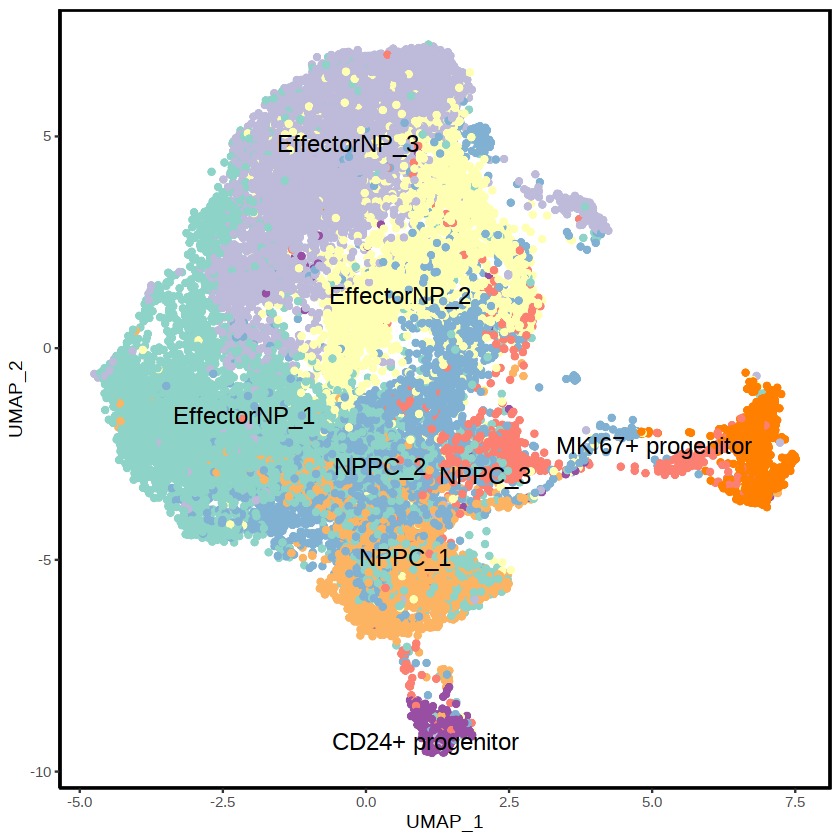

In [64]:
A.plot

In [65]:
pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_Fig2_NP_PENC_subcelltype_UMAP_change.pdf", width=9)
A.plot
dev.off()

png 
  2

In [98]:
saveRDS(np.detail.color.df,
        file="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/np_ppe_detail_refine2_color_df.Rds")

# plot some markers

In [8]:
select_markers <- 
    c("CD24", "CA3", "KRT19", "KRT8", 
      "MKI67", "TOP2A", "CENPF", "PTTG1")

In [20]:
pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_penc_subcelltype_markers_VlnPlot.pdf", width = 30, height = 14)
#options(repr.plot.width=14, repr.plot.height=10)
cowplot::plot_grid(plotlist = vln.list, align = "hv", nrow = 2, ncol=4)
dev.off()

png 
  2

In [11]:
vln.list <- VlnPlot(penc.seu, features = select_markers, ncol = 4, combine = F)

In [16]:
for (i in seq(length(vln.list))) {
  vln.list[[i]] <- vln.list[[i]] + NoLegend() + labs(x=NULL, y=NULL) +
    theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
}

In [21]:
#cowplot::plot_grid(plotlist = vln.list, align = "hv", nrow = 2, ncol=4)

In [ ]:
pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_PPE_subcelltypefeatureplot.pdf", width = 28, height = 15)
cowplot::plot_grid(plotlist = plot.list, align = "hv", nrow = 2, ncol=3)
dev.off()

# GSEA compare CD24 and MKI67

## get marker genes

In [22]:
only.pro.seu <- subset(penc.seu, idents = c("CD24+ progenitor", "MKI67+ progenitor"))

In [ ]:
only.pro.seu <- Seurat.wf(only.pro.seu)

only.pro.seu <-
  RunHarmony(
    only.pro.seu,
    group.by.vars = "sample_name"
  )

npcs = 50
resolution = 0.6
only.pro.seu <- 
  only.pro.seu %>% 
    RunUMAP(reduction = "harmony", dims = 1:npcs) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:npcs) %>% 
    FindClusters(resolution = resolution) %>% 
    identity()

In [28]:
only.pro.seu$ct.np.detail.refine %>% unique()

[1] "CD24+ progenitor"  "MKI67+ progenitor"

In [30]:
#DimPlot(only.pro.seu, label = T, group.by = "ct.np.detail.refine")

In [32]:
Idents(only.pro.seu) <- only.pro.seu$ct.np.detail.refine

In [ ]:
CD24.markers <- FindMarkers(object = only.pro.seu, ident.1 = "CD24+ progenitor", ident.2 = "MKI67+ progenitor", test.use = "MAST")

In [37]:
CD24.markers <- CD24.markers %>% filter(., p_val_adj < 0.05)

In [ ]:
MKI67.markers <- FindMarkers(object = only.pro.seu, ident.1 = "MKI67+ progenitor", ident.2 = "CD24+ progenitor", test.use = "MAST")

## GSEA analysis

In [75]:
library(msigdbr)

In [76]:
m_df <- msigdbr(species = "Homo sapiens")

In [77]:
H_t2g <- msigdbr(species = "Homo sapiens", category = "H") %>% 
  dplyr::select(gs_name, entrez_gene)

### CD24 

In [70]:
keep.entrezID <- bitr(rownames(CD24.markers), fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")
CD24.markers <- CD24.markers[keep.entrezID$SYMBOL,]
cd24.genes <- structure(unlist(CD24.markers$avg_log2FC), names=rownames(CD24.markers))
cd24.genes <- cd24.genes[order(cd24.genes, decreasing = T)]
names(cd24.genes) <- keep.entrezID$ENTREZID[match(names(cd24.genes), keep.entrezID$SYMBOL)]
em2 <- GSEA(cd24.genes, TERM2GENE = H_t2g, pvalueCutoff = 0.05)

wrong orderBy parameter; set to default `orderBy = "x"`



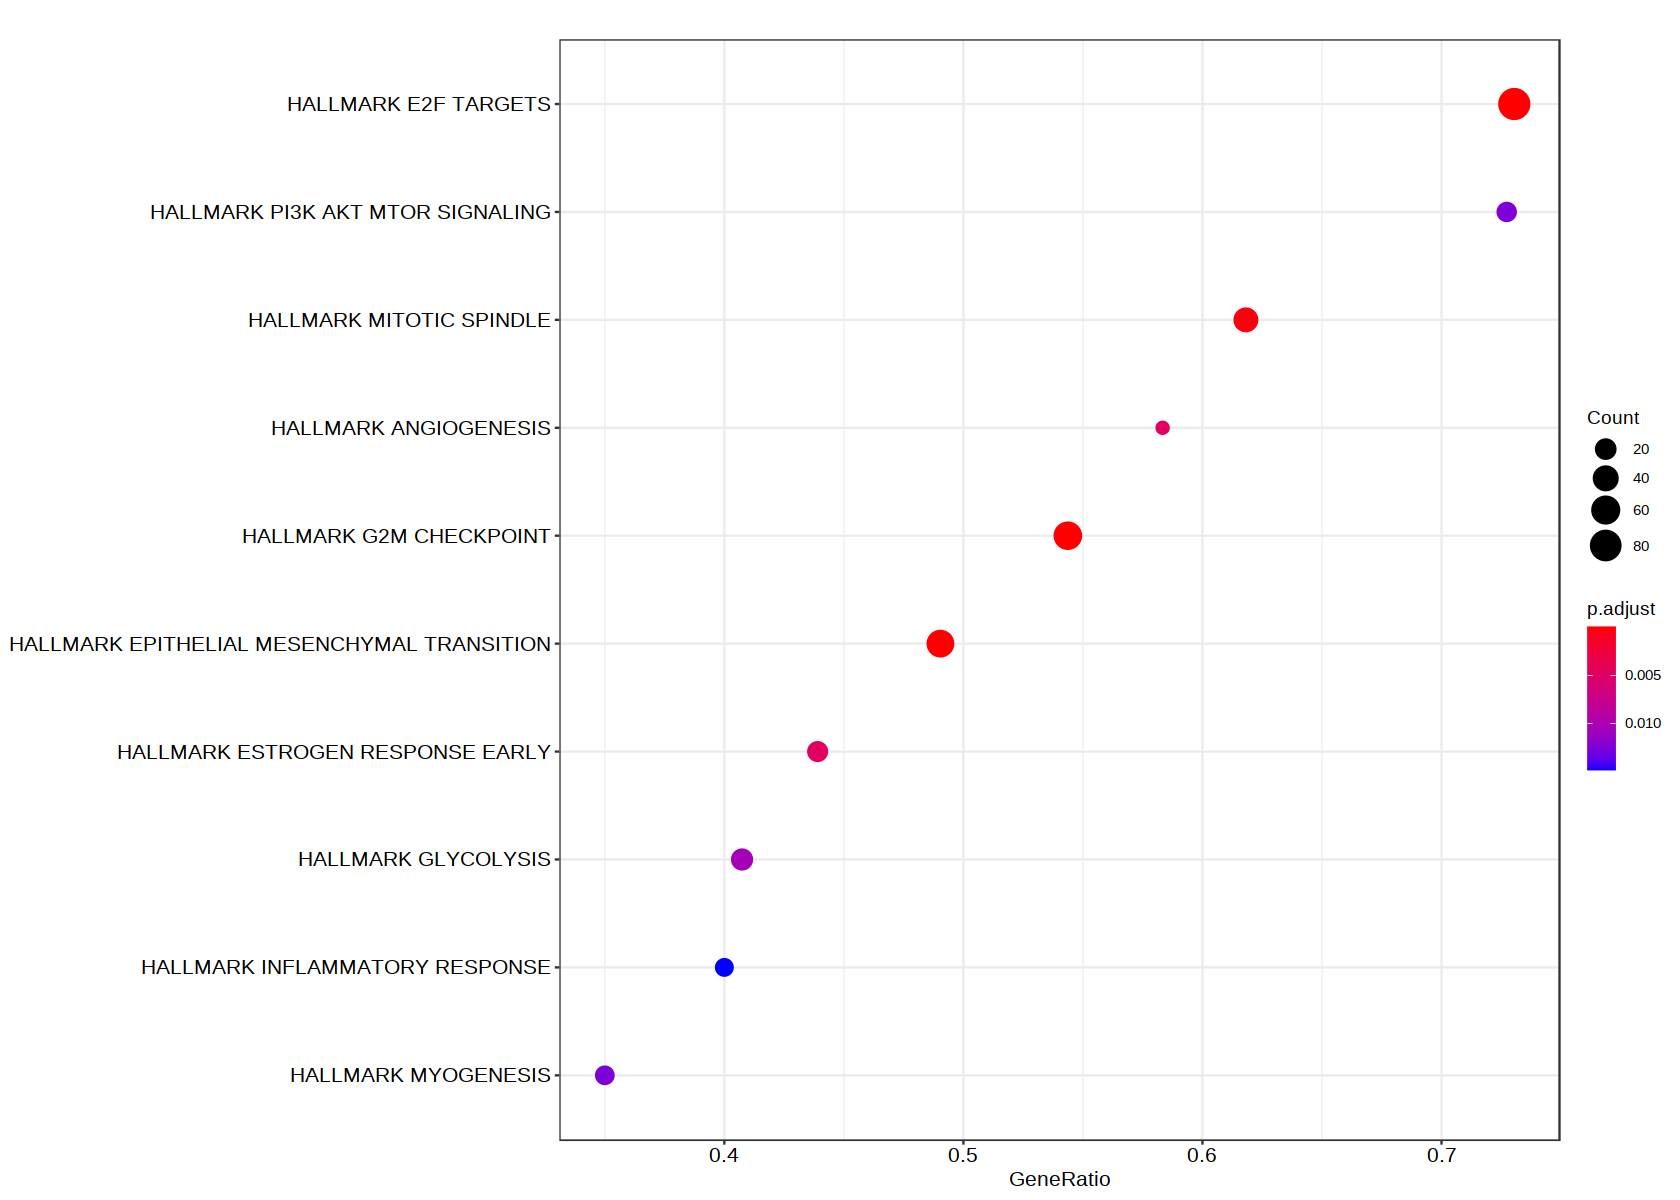

In [76]:
dotplot(em2)

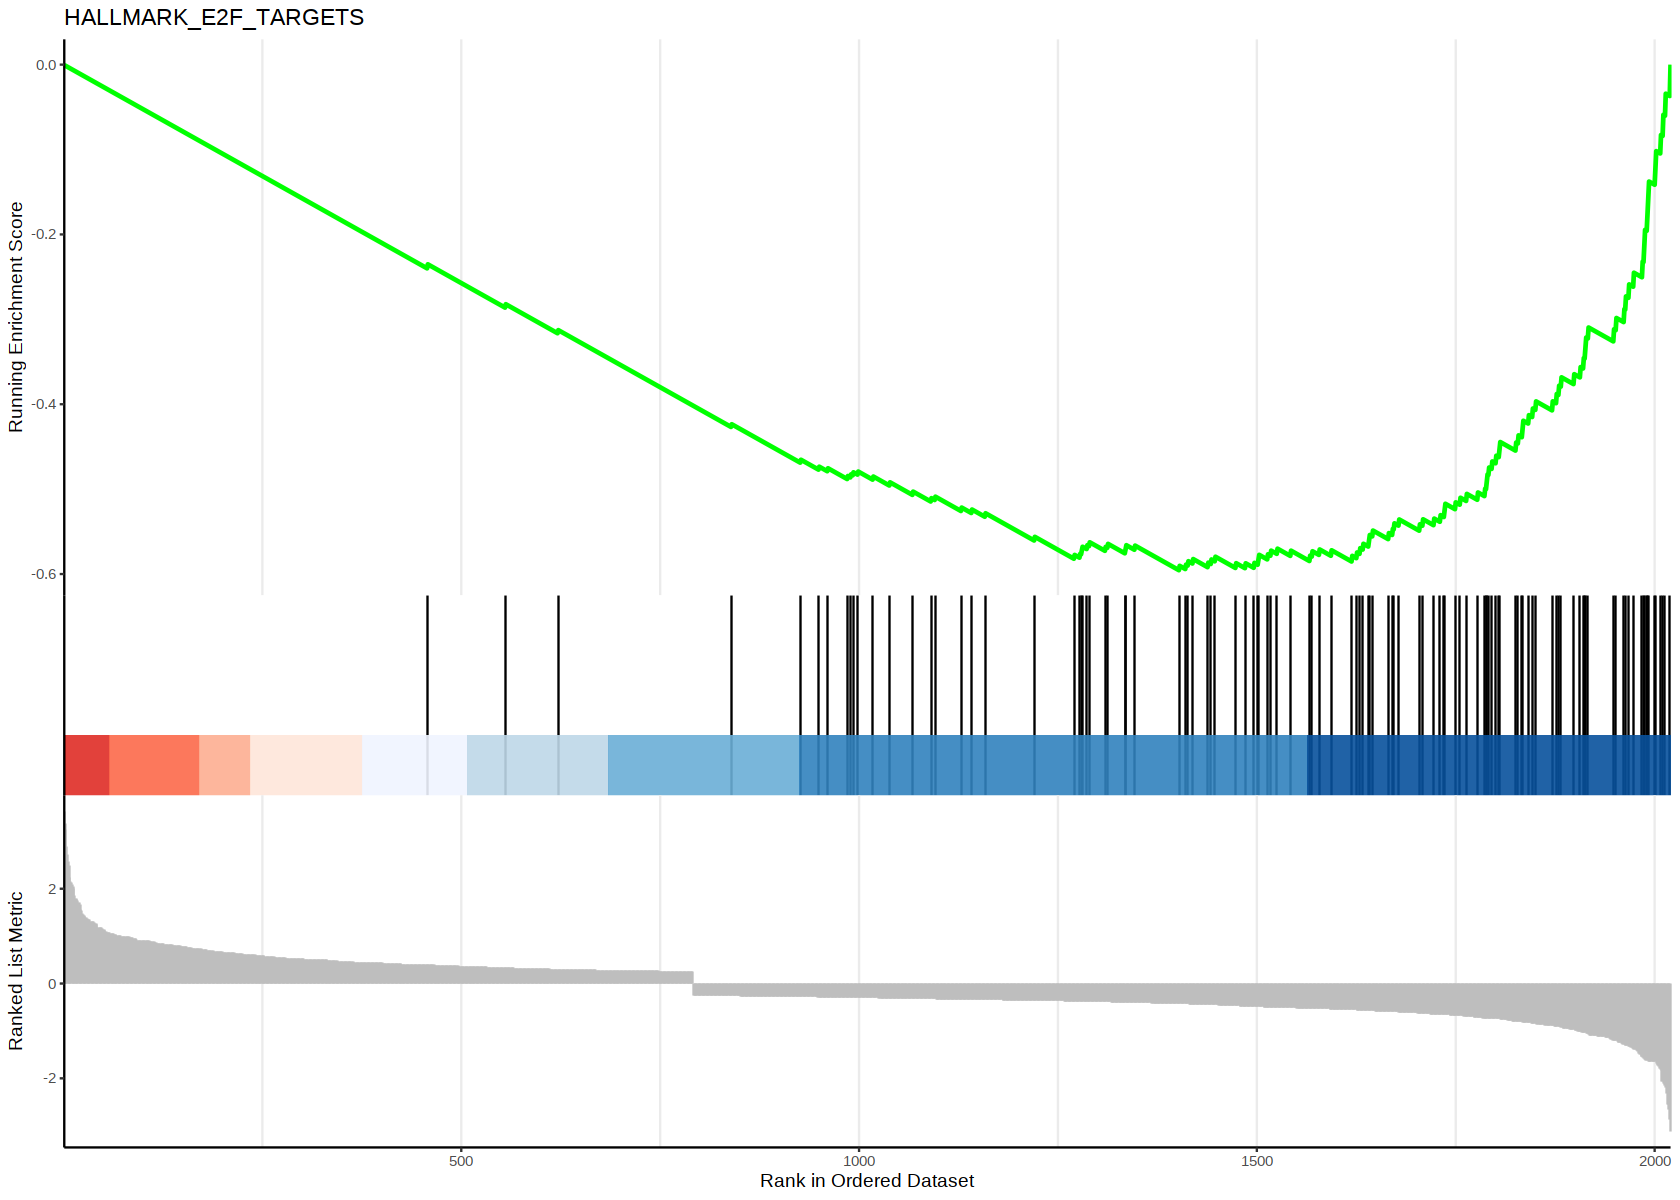

In [84]:
enrichplot::gseaplot2(em2, geneSetID = "HALLMARK_E2F_TARGETS", title = "HALLMARK_E2F_TARGETS")

In [82]:
em2@result$ID

[1] "HALLMARK_E2F_TARGETS"                      
 [2] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
 [3] "HALLMARK_G2M_CHECKPOINT"                   
 [4] "HALLMARK_MITOTIC_SPINDLE"                  
 [5] "HALLMARK_ESTROGEN_RESPONSE_EARLY"          
 [6] "HALLMARK_ANGIOGENESIS"                     
 [7] "HALLMARK_GLYCOLYSIS"                       
 [8] "HALLMARK_INFLAMMATORY_RESPONSE"            
 [9] "HALLMARK_PI3K_AKT_MTOR_SIGNALING"          
[10] "HALLMARK_MYOGENESIS"

### MKI67

In [ ]:
keep.entrezID <- bitr(rownames(MKI67.markers), fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL"), OrgDb = "org.Hs.eg.db")
MKI67.markers <- MKI67.markers[keep.entrezID$SYMBOL,]
mki67.genes <- structure(unlist(MKI67.markers$avg_log2FC), names=rownames(MKI67.markers))
mki67.genes <- mki67.genes[order(mki67.genes, decreasing = T)]
names(mki67.genes) <- keep.entrezID$ENTREZID[match(names(mki67.genes), keep.entrezID$SYMBOL)]
em2.mki67 <- GSEA(mki67.genes, TERM2GENE = H_t2g, pvalueCutoff = 0.05)

In [99]:
#dotplot(em2.mki67)

In [96]:
library(enrichplot)

In [97]:
?gseaplot2

In [110]:
pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_PPE_mki67_gsea_HALLMARK_INFLAMMATORY_RESPONSE.pdf")
enrichplot::gseaplot2(em2.mki67, geneSetID = "HALLMARK_INFLAMMATORY_RESPONSE", title = "Inflammatory response")
dev.off()

png 
  2

In [111]:
#enrichplot::gseaplot2(em2.mki67, geneSetID = "HALLMARK_INFLAMMATORY_RESPONSE", title = "HALLMARK_INFLAMMATORY_RESPONSE")

## check niche results GSEA

### CD24

In [119]:
cd24.nich <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/nichenetR_results/CD24_CCC_nichenet_results.Rds")

### MKI67

In [113]:
mki67.nich <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/nichenetR_results/MKI67_CCC_nichenet_results.Rds")

wrong orderBy parameter; set to default `orderBy = "x"`



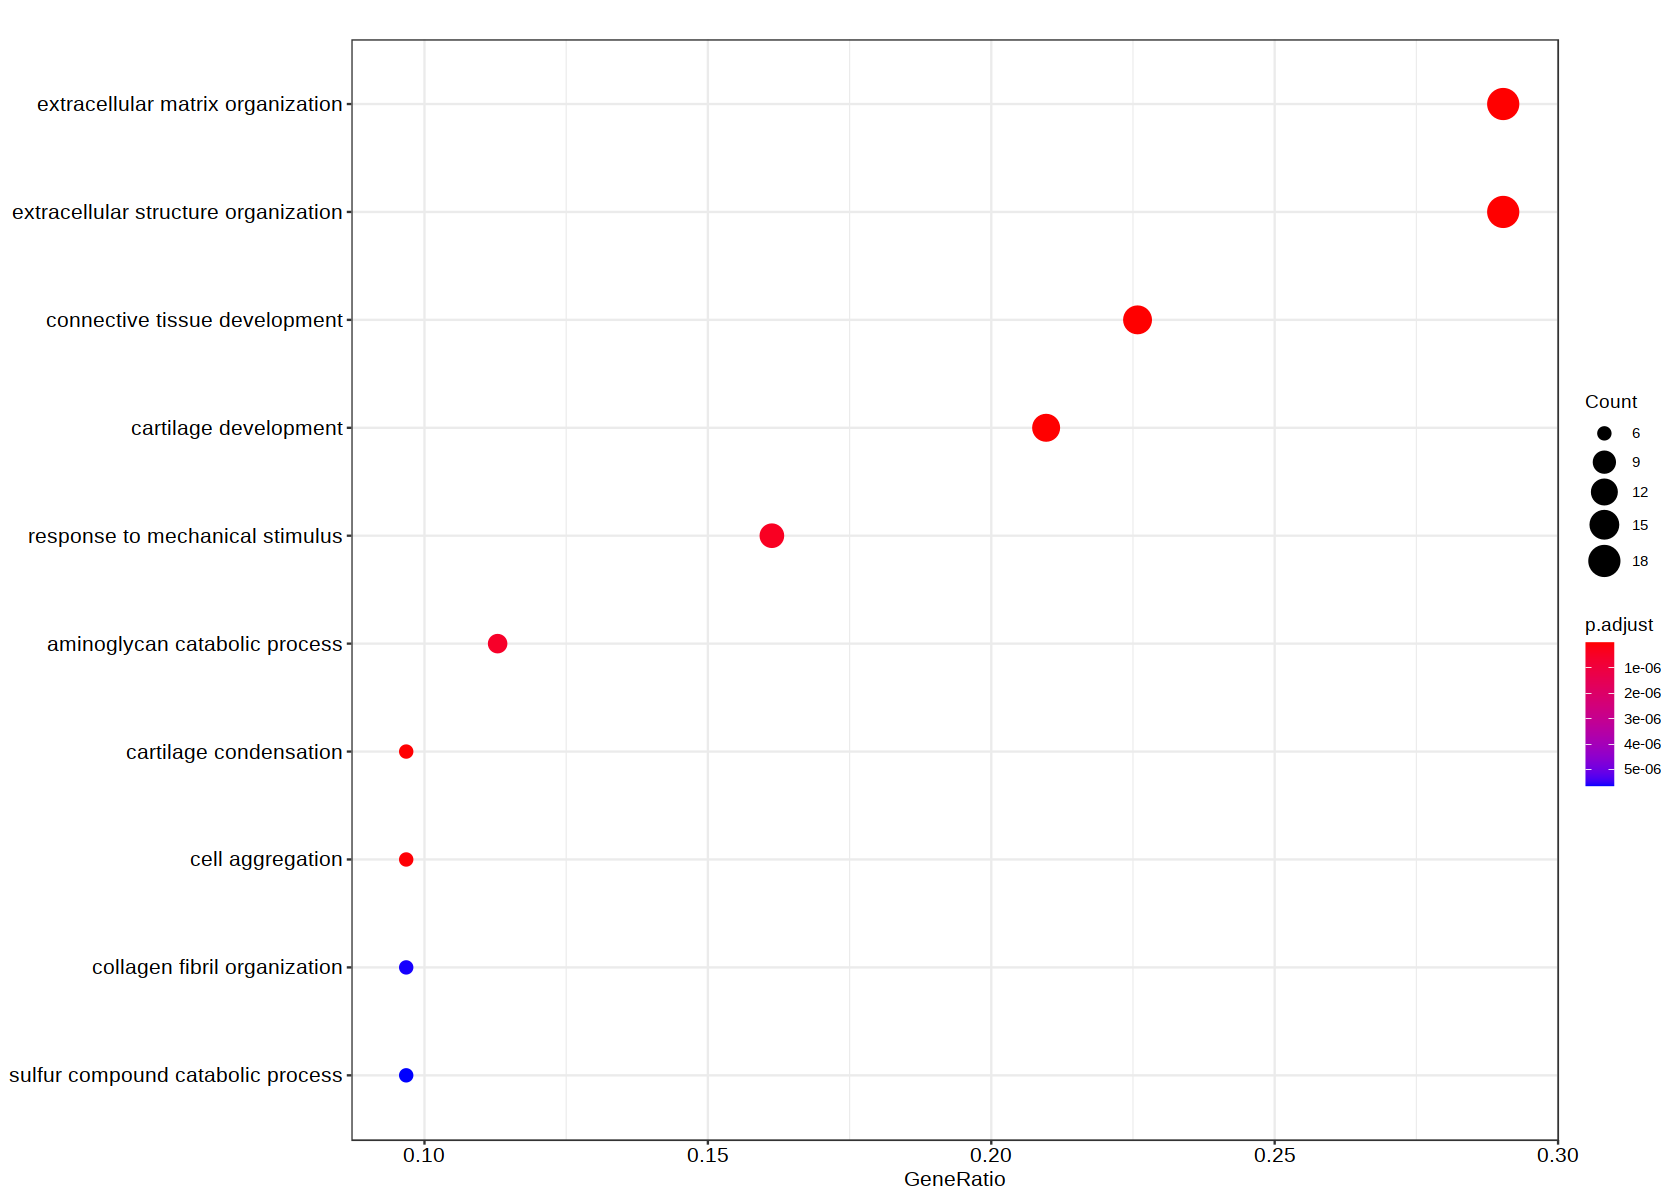

In [118]:
dotplot(mki67.nich$early$up.go$GO)

## plot heatmap

In [100]:
pro.all.markers <- FindAllMarkers(only.pro.seu, test.use = "MAST")

Calculating cluster CD24+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster MKI67+ progenitor


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [102]:
pro.all.markers %>%
  group_by(cluster) %>%
  top_n(n = 20, wt = avg_log2FC) -> topDE

In [101]:
# load colors
ppe.color.df <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/color_set/np_ppe_color_df.Rds")
pro.color <- filter(ppe.color.df, celltype %in% c("CD24+ progenitor", "MKI67+ progenitor"))
pro.color <- structure(pro.color$color, names=unlist(pro.color$celltype))

In [104]:
subcelltype.heatmap <- 
  DoHeatmap(only.pro.seu, 
            features = topDE$gene, 
            #cells = random.cells, 
            label = F,
             group.colors = pro.color) #+ 
#     scale_fill_gradient2(low="blue", mid="yellow" , high="red")

In [106]:
pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_cd24.vs.mki67_heatmap.pdf")
subcelltype.heatmap
dev.off()

png 
  2

# GSEA compare EffectorNP_1 and EffectorNP_3

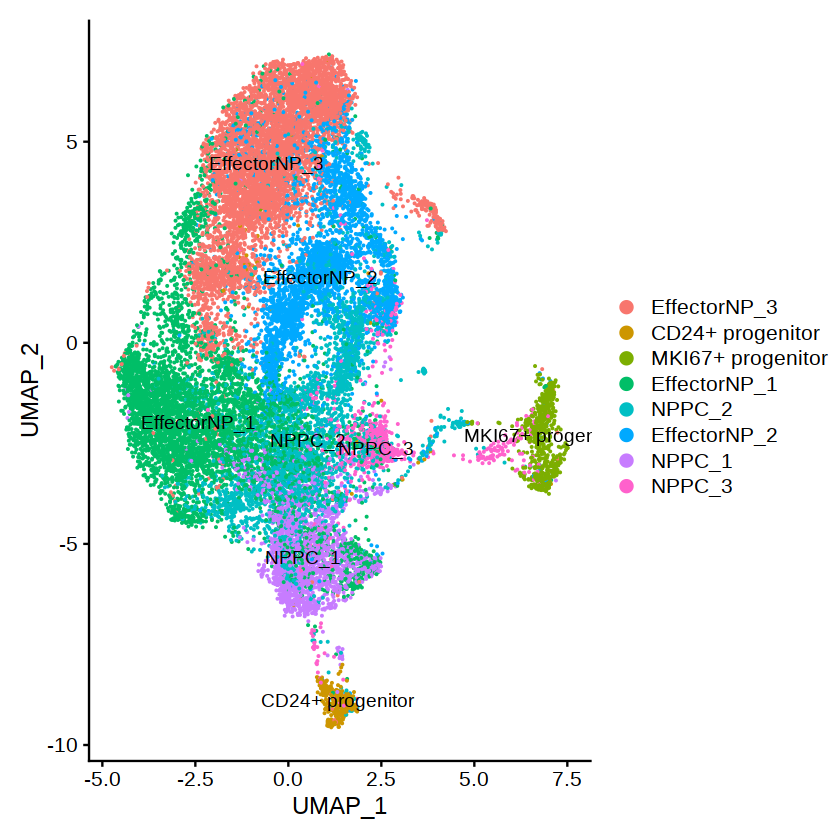

In [66]:
DimPlot(penc.seu, label = T)

In [121]:
effector1.markers <- FindMarkers(object = penc.seu, ident.1 = "EffectorNP_1", ident.2 = "EffectorNP_3", test.use = "MAST", min.pct = 0.2)
effector1.markers <- effector1.markers %>% filter(., p_val_adj < 0.05)


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [112]:
ef1.uni.markers <- FindMarkers(object = penc.seu, ident.1 = "EffectorNP_1", test.use = "MAST", min.pct = 0.2)
ef1.uni.markers <- ef1.uni.markers %>% filter(., p_val_adj < 0.05)


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [115]:
head(ef1.uni.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABI3BP,0,0.7844937,0.941,0.778,0
ACTB,0,-0.7783641,0.937,0.903,0
ANXA1,0,-1.2754158,0.889,0.879,0
ANXA5,0,-0.6243001,0.863,0.852,0
BAG3,0,-0.9692366,0.292,0.567,0
BGN,0,0.8018854,0.980,0.898,0


In [144]:
effector3.markers <- FindMarkers(object = penc.seu, ident.1 = "EffectorNP_3", ident.2 = "EffectorNP_1", test.use = "MAST", min.pct=0.2)
effector3.markers <- effector3.markers %>% filter(., p_val_adj < 0.05)


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



## EffectorNP_1 GSEA go

In [ ]:
gse <- gseGO(geneList=gene_list, 
             ont ="ALL", 
             keyType = "ENSEMBL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "none")

In [124]:
effector1.em <- getGSEA(marker.df = effector1.markers,
                        term2gene = H_t2g)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“2.85% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
leading edge analysis...

done...



In [127]:
effector1.em.go <- getGSEA.GO(marker.df = effector1.markers)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“2.85% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSiz

In [113]:
ef1.em <- 
    getGSEA(marker.df = ef1.uni.markers,
            term2gene = H_t2g)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“3.35% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (7.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
leading edge analysis...

done...



In [116]:
ef1.em.go <- 
    getGSEA.GO(marker.df = ef1.uni.markers)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“3.35% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (7.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSiz

In [122]:
effector1.markers <- effector1.markers[order(effector1.markers$avg_log2FC, decreasing = T),]

In [129]:
ef1.em.go@result %>% filter(Description == "cartilage development")

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0051216,GO:0051216,cartilage development,23,0.5947335,2.96888,0.0005205622,0.01916866,0.01601044,108,"tags=65%, list=15%, signal=57%",1280/633/389084/1311/1302/11061/1301/7076/4256/176/1116/579/150356/7227/8200


In [ ]:
effector1.em.go

In [147]:
effector1.em.go2@result %>% filter(Description == "glycosaminoglycan biosynthetic process")

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0006024,GO:0006024,glycosaminoglycan biosynthetic process,14,0.5609061,2.268778,0.0005583473,0.03233683,0.02854993,201,"tags=86%, list=26%, signal=64%",VCAN/BGN/ACAN/FMOD/CHST3/OGN/B3GNT7/PRELP/CSGALNACT1/HS3ST1/CHPF/ST3GAL1


In [194]:
#enrichplot::gseaplot2(effector1.em.go, geneSetID = "GO:0051216", title = "glycosaminoglycan biosynthetic process")

In [145]:
pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_PPE_EffectorNP_1_gsea_cartilage_development.pdf")
enrichplot::gseaplot2(effector1.em.go, geneSetID = "GO:0051216", title = "cartilage development")
dev.off()

png 
  2

In [149]:
pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_PPE_EffectorNP_1_gsea_glycosaminoglycan_biosynthetic_process.pdf")
enrichplot::gseaplot2(effector1.em.go, geneSetID = "GO:0051216", title = "glycosaminoglycan biosynthetic process")
dev.off()

png 
  2

## boxplot some gene exp

In [ ]:
library(ggpubr)

In [177]:
ef1.gene.p <- 
    celltype.genes.exp(seuObj = penc.seu,
                       select.genes = c("CHI3L1","MGP","BGN","TIMP1"))
ef1.gene.p <- ef1.gene.p %>% filter(., celltype %in% c("EffectorNP_1", "EffectorNP_3"))
ef1.gene.p$celltype <- as.character(ef1.gene.p$celltype)
ef1.gene.p$celltype <- factor(ef1.gene.p$celltype, levels = c("EffectorNP_1", "EffectorNP_3"))

box.p <- 
    facet(ggboxplot(ef1.gene.p, x="celltype", y="exp", color="celltype", ylab = "Normalized Expression") + theme_bw() + 
          theme(legend.position = "right") +
         scale_color_manual(values=np.detail.color[c("EffectorNP_1", "EffectorNP_3")]), facet.by = "gene", ncol = 2,nrow=3) +
         stat_compare_means(label = "p.signif", method = "wilcox.test") +
        theme(legend.key.size = unit(2, 'cm'))

pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS2_NP_PPE_effector1VS3_someGenes.pdf", height = 9)
box.p
dev.off()

In [135]:
effector1.em.go2 <- setReadable(effector1.em.go, OrgDb = org.Hs.eg.db, keyType="ENTREZID")

In [104]:
effector3.em.go <- 
    getGSEA.GO(marker.df = effector3.markers)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“2.85% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSiz

In [107]:
ef3.ego.df <- as.data.frame(effector3.em.go)

In [100]:
?grepl

In [111]:
#dotplot(effector1.em)

In [80]:
effector3.em <- getGSEA(marker.df = effector3.markers,
                        term2gene = H_t2g)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“2.85% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
leading edge analysis...

done...



In [110]:
#dotplot(effector3.em)

In [109]:
#VlnPlot(penc.seu, idents = c("EffectorNP_1", "EffectorNP_3"), features = c("COL2A1"))

In [85]:
effector3.markers <- effector3.markers[order(effector3.markers$avg_log2FC, decreasing = T),]

In [86]:
effector1.markers <- effector3.markers[order(effector1.markers$avg_log2FC, decreasing = T),]

# GSEA compare NPPC_1 NPPC_2 NPPC_3

In [195]:
NPPC1.VS3.markers <- FindMarkers(penc.seu, ident.1="NPPC_1", ident.2="NPPC_3", test.use = "MAST")


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [196]:
NPPC1.VS3.markers <- NPPC1.VS3.markers %>% filter(., p_val_adj < 0.05)

In [197]:
NPPC1.VS3.markers <- NPPC1.VS3.markers[order(NPPC1.VS3.markers$avg_log2FC, decreasing = T),]

In [198]:
NPPC1.VS3.gseGO <- 
    getGSEA.GO(marker.df = NPPC1.VS3.markers)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(marker.df), fromType = "SYMBOL", toType = c("ENTREZID", :
“2.52% of input gene IDs are fail to map...”
preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.04% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSi

wrong orderBy parameter; set to default `orderBy = "x"`



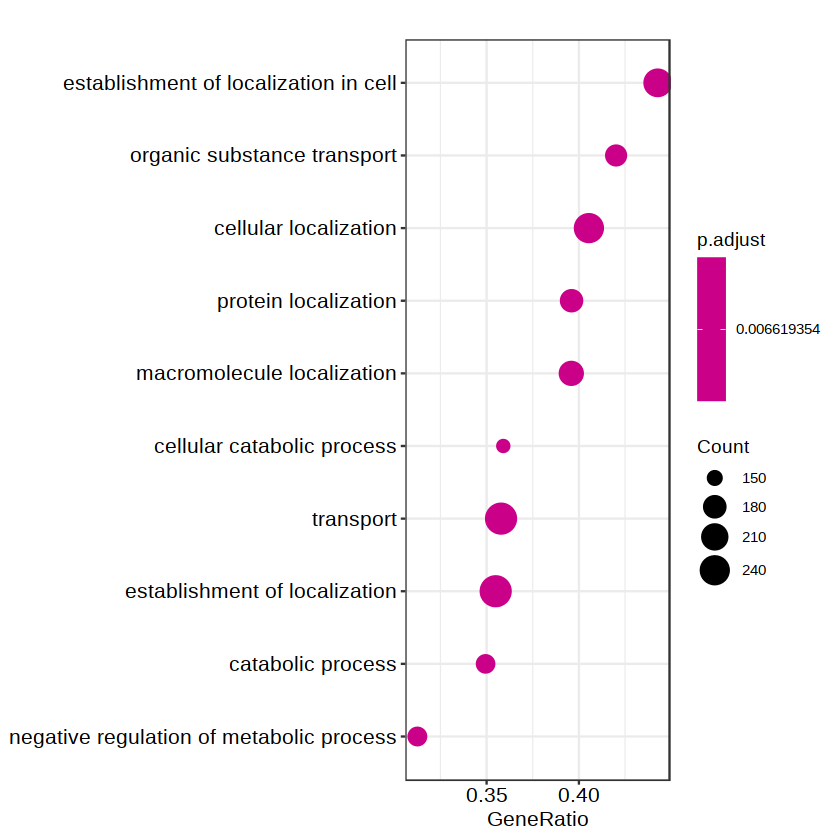

In [199]:
dotplot(NPPC1.VS3.gseGO)

# subset to compare

In [7]:
unique(Idents(penc.seu))

[1] EffectorNP_3      CD24+ progenitor  MKI67+ progenitor EffectorNP_1     
[5] NPPC_2            EffectorNP_2      NPPC_1            NPPC_3           
8 Levels: EffectorNP_3 CD24+ progenitor MKI67+ progenitor ... NPPC_3

## subset NPPCs

In [8]:
nppc.sub <- subset(penc.seu, idents = c("NPPC_1", "NPPC_2", "NPPC_3"))

In [ ]:
# pre-process
nppc.sub <- Seurat.wf(nppc.sub)
# run harmony correct batch effector
nppc.sub <-
  RunHarmony(
    nppc.sub,
    group.by.vars = "sample_name"
  )
# re-cluster use harmony embedding
nppc.sub <- nppc.sub %>% 
  RunUMAP(reduction = "harmony", dims = 1:70) %>% 
  FindNeighbors(reduction = "harmony", dims = 1:70) %>% 
  FindClusters(resolution = 1.5) %>% 
  identity()


In [12]:
Idents(nppc.sub) <- nppc.sub$ct.np.detail.refine2

In [ ]:
nppc.markers <- FindAllMarkers(nppc.sub, min.pct = 0.2, only.pos = T, test.use = "MAST")

In [20]:
nppc.markers <- nppc.markers %>% filter(., p_val_adj < 0.05)

In [22]:
saveRDS(nppc.markers,
        file="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/NPPC_sub_markers.Rds")

### plot heatmap

In [24]:
nppc.markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC) -> topNPPC

In [28]:
nppc.heatmap <- 
  DoHeatmap(nppc.sub, 
            features = topNPPC$gene, 
            #cells = random.cells, 
            label = T,
             group.colors = np.detail.color) #+ 


Warning message in DoHeatmap(nppc.sub, features = topNPPC$gene, label = T, group.colors = np.detail.color):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: TPM4, MALAT1, MEG3, RPL30, RPS27”


In [30]:
pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS3_1_PENC_nppc_sub_heatmap.pdf")
nppc.heatmap
dev.off()

png 
  2

### boxplot some signature

In [41]:
library(ggpubr)

In [37]:
nppc.gene.p <- 
    celltype.genes.exp(seuObj = nppc.sub,
                       select.genes = c("COMP", "RPS27", "TMSB4X"))
nppc.gene.p$celltype <- as.character(nppc.gene.p$celltype)
nppc.gene.p$celltype <- factor(nppc.gene.p$celltype, levels = c("NPPC_1", "NPPC_2", "NPPC_3"))

In [47]:
box.p <- 
    facet(ggboxplot(nppc.gene.p, x="celltype", y="exp", color="celltype", ylab = "Normalized Expression") + theme_bw() + 
          theme(legend.position = "right") +
         scale_color_manual(values=np.detail.color[c("NPPC_1", "NPPC_2", "NPPC_3")]), facet.by = "gene", ncol = 3,nrow=1) +
         stat_compare_means(label = "p.signif", method = "wilcox.test") +
        theme(legend.key.size = unit(2, 'cm'))


In [51]:

pdf(file = "~/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS3_1_PENC_NPPCs_someGenes.pdf", height = 5, width = 12)
box.p
dev.off()

png 
  2

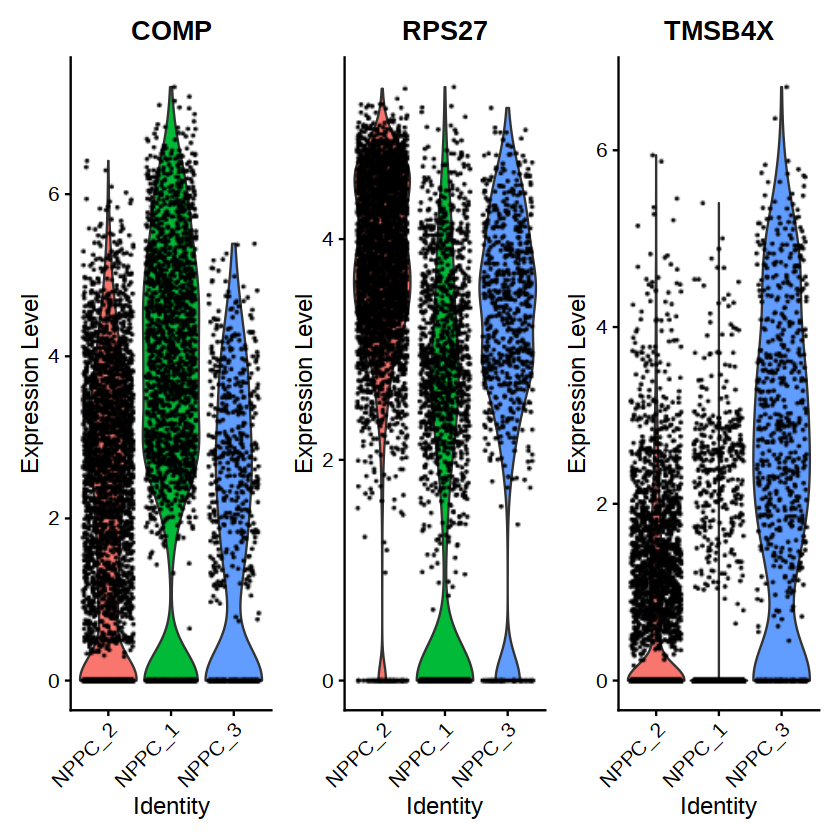

In [35]:
VlnPlot(nppc.sub, features = c("COMP", "RPS27", "TMSB4X"))

In [25]:
np.detail.color

CD24+ progenitor        EffectorNP      EffectorNP_1      EffectorNP_2 
        "#984EA3"         "#E41A1C"         "#8DD3C7"         "#FFFFB3" 
     EffectorNP_3             HomNP              HTNP MKI67+ progenitor 
        "#BEBADA"         "#377EB8"         "#4DAF4A"         "#FF7F00" 
             NPPC            NPPC_1            NPPC_2            NPPC_3 
        "#FFFF33"         "#FDB462"         "#80B1D3"         "#FB8072"

## subset EffectorNPs

In [15]:
effector.sub <- subset(penc.seu, idents = c("EffectorNP_1", "EffectorNP_2", "EffectorNP_3"))

In [ ]:
# pre-process
effector.sub <- Seurat.wf(effector.sub)
# run harmony correct batch effector
effector.sub <-
  RunHarmony(
    effector.sub,
    group.by.vars = "sample_name"
  )
# re-cluster use harmony embedding
effector.sub <- effector.sub %>% 
  RunUMAP(reduction = "harmony", dims = 1:70) %>% 
  FindNeighbors(reduction = "harmony", dims = 1:70) %>% 
  FindClusters(resolution = 1.5) %>% 
  identity()


In [17]:
Idents(effector.sub) <- effector.sub$ct.np.detail.refine2

In [ ]:
effector.markers <- FindAllMarkers(effector.sub, min.pct = 0.2, only.pos = T, test.use = "MAST")

In [19]:
effector.markers <- effector.markers %>% filter(., p_val_adj < 0.05)

In [21]:
saveRDS(effector.markers,
        file="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/effectorNP_sub_markers.Rds")

### plot heatmap

In [52]:
effector.markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC) -> topEffector

In [55]:
effector.heatmap <- 
  DoHeatmap(effector.sub, 
            features = topEffector$gene, 
            #cells = random.cells, 
            label = T,
             group.colors = np.detail.color) #+ 


Warning message in DoHeatmap(effector.sub, features = topEffector$gene, label = T, :
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: BGN”


In [57]:
pdf("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/plots/paper_plots/new_FigS3_1_PENC_effector_sub_heatmap.pdf")
effector.heatmap
dev.off()

png 
  2

# check ratio

In [127]:
penc.count <- table(penc.seu@meta.data$ct.np.detail.refine2, penc.seu@meta.data$orig.ident) %>% as.data.frame()
colnames(penc.count) <- c("cell.type", "grade", "cell.num")
penc.count <- 
    penc.count %>% group_by(grade) %>% do({
        df <- .
        df$cell.ratio <- df$cell.num / sum(df$cell.num) * 100
        df
    })

In [130]:
use.color <- np.detail.color[unique(penc.seu@meta.data$ct.np.detail.refine2)]

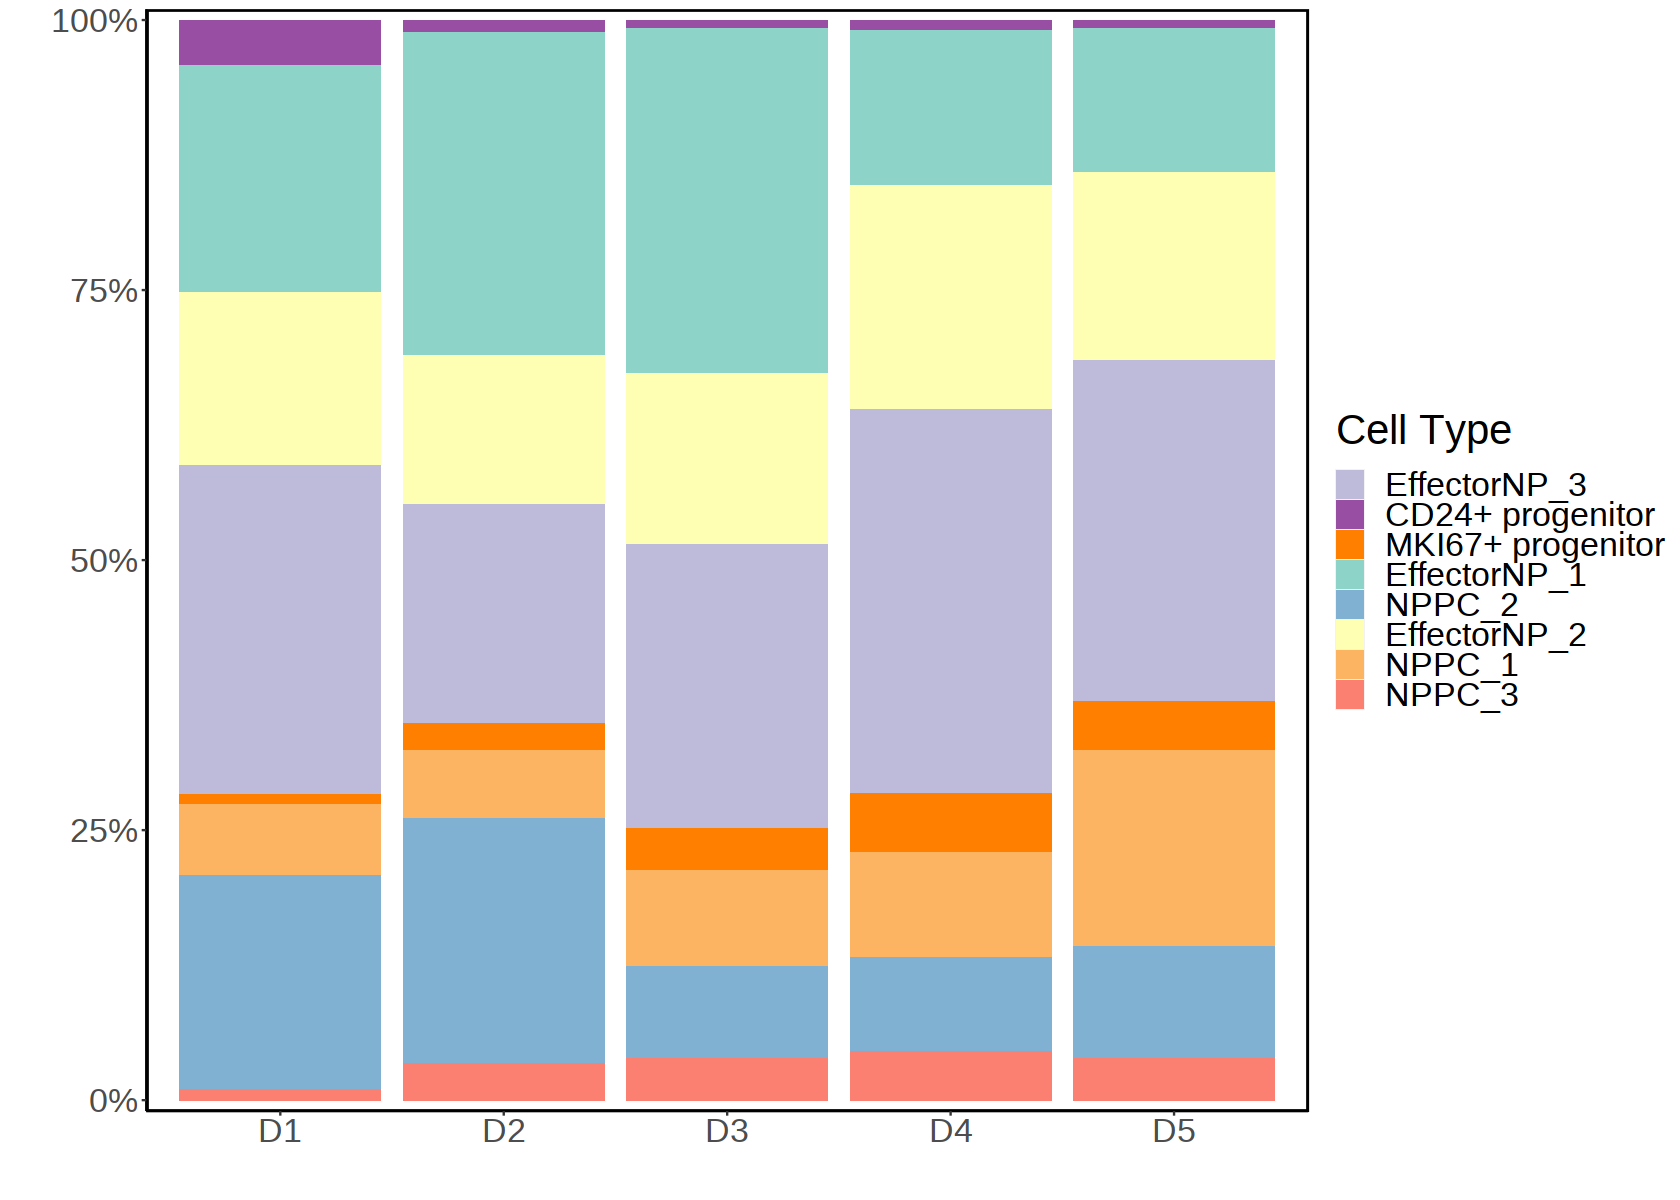

In [132]:
penc.count %>% 
    ggplot() +
    geom_bar(aes(x=grade, y=cell.ratio, fill=cell.type), stat = "identity") +
      scale_fill_manual(values = use.color) + 
      scale_y_continuous(limits = c(0,100), expand = c(0.01,0.01), 
                         breaks = seq(0,100, 25), labels = paste0(seq(0,100,25), "%")) +
      labs(x="", y="", fill="Cell Type") + 
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            panel.border = element_rect(colour = "black", fill=NA, size=1),
            axis.line = element_line(colour = "black"),
            axis.text.x = element_text(size = 20),
            axis.text.y = element_text(size = 20),
            axis.title = element_text(size = 25),
            legend.text = element_text(size = 20),
            legend.title = element_text(size = 25))

# monocle3

In [150]:
library(monocle3)

In [151]:
cds <- 
    as.cell_data_set(penc.seu)

Warning message:
“Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object”


In [152]:
cds <- cluster_cells(cds = cds, reduction_method = "UMAP")
cds <- learn_graph(cds, use_partition = TRUE)

  |======================================================================| 100%


In [155]:
?learn_graph

In [156]:
root.cells <- rownames(penc.seu@meta.data %>% filter(., ct.np.detail.refine2 %in% c("CD24+ progenitor", "MKI67+ progenitor")))

In [158]:
cds <- order_cells(cds, reduction_method = "UMAP", root_cells = root.cells)

In [163]:
class(cds)

[1] "cell_data_set"
attr(,"package")
[1] "monocle3"

# monocle DEG 

In [14]:
suppressMessages({
    library(DT);
    library(monocle)
})


## load slingshot results

In [10]:
final.sds <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/finale_penc_slingshot_resds.Rds")

In [11]:
final.ptime.df <- 
    readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/finale_penc_slingshot_ptime_df.Rds")

In [ ]:
subset(penc.seu, cells = )

In [ ]:
counts.mx <- Obj@assays$RNA@counts
cell_metadata <- Obj@meta.data
gene_annotation <- data.frame(gene_short_name = rownames(counts.mx))
rownames(gene_annotation) <- rownames(counts.mx)
pd <- new("AnnotatedDataFrame", data = cell_metadata)
fd <- new("AnnotatedDataFrame", data = gene_annotation)

In [ ]:
cds2 <- newCellDataSet(counts.mx, 
                      phenoData = pd, 
                      featureData = fd,
                      expressionFamily = negbinomial.size())

In [ ]:
# normalize
cds2 <- estimateSizeFactors(cds2)
cds2 <- estimateDispersions(cds2)

In [ ]:
diff_test_res2 <- filter(diff_test_res, qval <= 0.05)
diff_test_res2 <- diff_test_res2[order(diff_test_res2$qval),]

# trans to scanpy

In [16]:
suppressMessages({
    library(Seurat)
    library(SeuratDisk)
    library(SeuratWrappers)
    library(harmony)  
})

## use SeuratDisk

In [17]:
all.unspliced.mx <- readRDS("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/RNA_velocity/all_samples_unsliced_matrix.Rds")

In [18]:
Seurat2adata <- function(Seurat.obj, unspliced.mx, save.path, sample.name){
    # 1. get unspliced matrix
    nmat <- unspliced.mx[rownames(Seurat.obj),colnames(Seurat.obj)]
    unspliced.assay <- CreateAssayObject(counts = nmat)
    # 2.add to seurat obj
    Seurat.obj@assays$spliced <- Seurat.obj@assays$RNA
    Seurat.obj[["unspliced"]] <- unspliced.assay
    # 3. conver to adata
    # create source
    h5Seurat.path <- file.path(save.path, paste0(sample.name, ".h5Seurat"))
    SaveH5Seurat(Seurat.obj, filename = h5Seurat.path)
    # conver
    Convert(h5Seurat.path, dest = "h5ad")
}

In [20]:
Seurat2adata(Seurat.obj = penc.seu,
             unspliced.mx = all.unspliced.mx,
             save.path = "/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC",
             sample.name = "new_PENC")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding counts for spliced

Adding data for spliced

Adding scale.data for spliced

Adding variable features for spliced

Adding feature-level metadata for spliced

Adding counts for unspliced

Adding data for unspliced

No variable features found for unspliced

No feature-level metadata found for unspliced

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Adding cell embeddings for harmony

Adding loadings for harmony

Adding projected loadings for harmony

Adding standard deviations for harmony

No JackStraw data for harmony

Validating h5Seurat file



## use loom

In [22]:
library(loomR)

In [23]:
lfile <- as.loom(x=penc.seu,filename="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_penc.loom")
lfile$close_all()

Saving data from RNA as /matrix

Adding slot counts for assay RNA

Adding layer counts

Adding slot scale.data for assay RNA

Adding layer scale.data

Adding col attribute CellID

Adding col attribute orig.ident

Adding col attribute nCount_RNA

Adding col attribute nFeature_RNA

Adding col attribute percent.mt

Adding col attribute pANN_0.25_0.19_346

Adding col attribute DF.classifications_0.25_0.19_346

Adding col attribute pANN_0.25_0.21_400

Adding col attribute DF.classifications_0.25_0.21_400

Adding col attribute pANN_0.25_0.3_429

Adding col attribute DF.classifications_0.25_0.3_429

Adding col attribute pANN_0.25_0.005_275

Adding col attribute DF.classifications_0.25_0.005_275

Adding col attribute pANN_0.25_0.28_510

Adding col attribute DF.classifications_0.25_0.28_510

Adding col attribute pANN_0.25_0.24_572

Adding col attribute DF.classifications_0.25_0.24_572

Adding col attribute pANN_0.25_0.3_324

Adding col attribute DF.classifications_0.25_0.3_324

Adding col attri

# run slingshot use Scanpy diffusionmap

In [26]:
scanp.difm <- 
    read.csv("/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/Scanpy_diffusionmap_PENC.txt",
             sep='\t',
             stringsAsFactors=F, header=T)

In [28]:
colnames(scanp.difm) <- c("cellname", paste0("DM_",seq(15)))

In [31]:
scanp.difm$celltype <- penc.seu@meta.data[scanp.difm$cellname, "ct.np.detail.refine2"]

In [45]:
difm.sub <- scanp.difm[,c("DM_1", "DM_2")]
rownames(difm.sub) <- scanp.difm$cellname

In [40]:
library(slingshot)

In [50]:
scanp.sds <- 
    slingshot(difm.sub, 
              clusterLabels = scanp.difm$celltype)

In [51]:
slingLineages(scanp.sds)

$Lineage1
[1] "CD24+ progenitor" "NPPC_3"           "EffectorNP_3"     "NPPC_2"          
[5] "EffectorNP_2"     "EffectorNP_1"    

$Lineage2
[1] "CD24+ progenitor" "NPPC_3"           "EffectorNP_3"     "NPPC_2"          
[5] "EffectorNP_2"     "NPPC_1"          

$Lineage3
[1] "CD24+ progenitor"  "NPPC_3"            "MKI67+ progenitor"

In [48]:
embed.mx <- difm.sub
cluster.labels <- scanp.difm$celltype
slinshot.mats <- list(embed.mx, cluster.labels)
saveRDS(slinshot.mats,
        file="/mnt/data/home/lzz/project/2020-6-18-IVDD_scRNA/results/combin_results/new_results/NP/PENC/new_penc_scanpy_slingshot_mats.Rds")